In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform, TexturesVertex
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd

from utils import general_utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [4]:
# shapenet
dataset_type = "shapenet"
class_name = "04530566"
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)

# regular ---
#input_img_dir = "data/input_images/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
# atlasnet
#input_mesh_dir = "/home/svcl-oowl/brandon/research/AtlasNet/data/pytorch_3d_render_recs/{}".format(class_name)
# pix2mesh
#input_mesh_dir = "/home/svcl-oowl/brandon/research/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
# occnet
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)

# sym ---
input_img_dir = "data/input_images/sym_pytorch3d_shapenet_renders/{}/rgba".format(class_name)
input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/{}/generation/meshes".format(class_name)


# pix3d
#dataset_type = "pix3d"
#class_name = "chair"
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pix3d/{}/generation/meshes".format(class_name)
#input_img_dir = "data/pix3d_images_processed_filtered/{}/rgba".format(class_name)
#gt_shapes_list_path = "data/gt_shapes_path_lists/pix3d_{}_gt_shapes.lst".format(class_name)

In [5]:
cfg_path = "configs/test.yaml"
#cfg_path = "configs/final_refinement_params.yaml"
#cfg_path = "configs/ablation_4_params.yaml"

device = torch.device("cuda:0")
cfg = general_utils.load_config(cfg_path, "configs/default.yaml")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))
instances = [str(path).split('/')[-1].replace(".obj", "") for path in list(Path(input_mesh_dir).rglob("*.obj"))]
#instances = instances[:2]
#instances = ['f230308627e5edaa9d796919a8d71368', 'd409dbda0a34a953c9020fbe6b2ff6']

# airplane sym
#instances = ["9e998a06601e9f944b2bd73664dd1844"]
#instances = ["5eb91263da1f0bf3e816c75152573ee0"]
#instances = ["5eb91263da1f0bf3e816c75152573ee0", "9e998a06601e9f944b2bd73664dd1844"]
# chair sym
#instances = ["5ce845f80b1d407282dde982679cd879", "f7ffdf91b66c0c989c9513cebb0fb44c", "f9e7dcaf9b7a9eb3c9befbd10d7e29b", "b58a0307a86959bd564f6f5de611dfed"]
# speakers sym
#instances = ['8aea25f1090e419c9f78b1e1185445c4', '400fb89ed6cc3d2bf1acfa9a5200e941', '799a7910c5084f1a799c6c3b2fff049', 'fad354295b4c0fdb55266ce6303fe1e0']
# gun sym
#instances = ['2a45063d7d03b865ebeab56de94a5835', '11b137bf4816ed40f4c39a35147bf949', '84de9995b0a416b5fb5c1b0f759e2bc1', '809d2439412bcdac896cb6094e2801d6', '938be7a1544953152c3271e911ffe19', '235853d2947a90e65e9786b1603f45c8']
#instances = ['235853d2947a90e65e9786b1603f45c8']
# boat sym
instances = ['203c2cac2c46e06c320fa6e2cd857828', '2362039302d80f99f2c9de96bdb467eb', 'e5a3728a3b5a7ecd1d2d2f3b717d35d5']

print(instances)
print(cfg)

['203c2cac2c46e06c320fa6e2cd857828', '2362039302d80f99f2c9de96bdb467eb', 'e5a3728a3b5a7ecd1d2d2f3b717d35d5']
{'dataset': {'input_dir_mesh': 'data/onet_chair_pix3d_dann_simplified', 'input_dir_img': 'data/img_pix3d_chair/chair'}, 'brute_force_pose_est': {'num_azims': 20, 'num_elevs': 20, 'num_dists': 40}, 'model': {'point_encoder': 'ResnetPointnet', 'image_encoder': 'Resnet18', 'deformation_decoder': 'FCStandard', 'latent_dim_pointnet': 512, 'latent_dim_resnet': 256, 'decoder_dim': 1024, 'output_delta_V': True}, 'refinement': {'num_iterations': 600, 'learning_rate': 7e-05}, 'training': {'semantic_dis_lam': 0, 'img_sym_num_azim': 3, 'img_sym_lam': 75, 'sil_lam': 10, 'vertex_sym_lam': 100, 'vertex_asym': True, 'l2_lam': 100, 'lap_smoothness_lam': 10, 'normal_consistency_lam': 10, 'img_sym_bias': 0.0005, 'vertex_sym_bias': 0.0005}, 'semantic_dis_training': {'output_dir': 'out', 'input_dir_pose': 'data/onet_chair_pix3d_dann_simplified_processed/pred_poses.p', 'dataset_meshes_list_path': 'da

/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/04530566/generation/meshes/203c2cac2c46e06c320fa6e2cd857828.obj
1.3974359035491943 40.0 267.15045166015625 gt


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


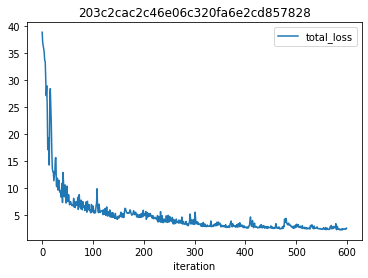

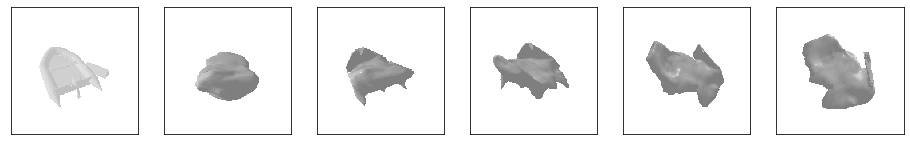

/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/04530566/generation/meshes/2362039302d80f99f2c9de96bdb467eb.obj
0.692307710647583 40.0 301.5679626464844 gt


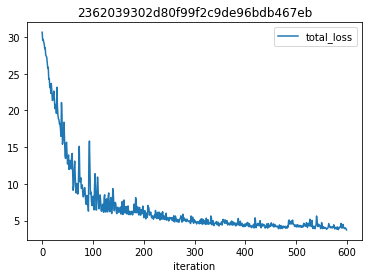

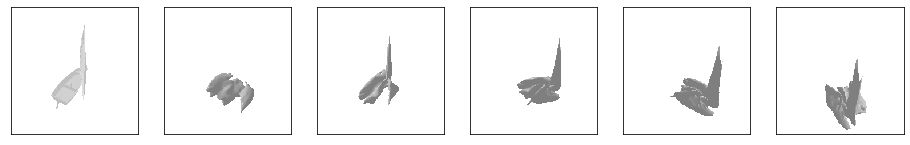

/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/04530566/generation/meshes/e5a3728a3b5a7ecd1d2d2f3b717d35d5.obj
1.3974359035491943 40.0 165.1175537109375 gt


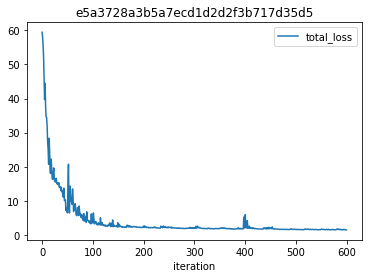

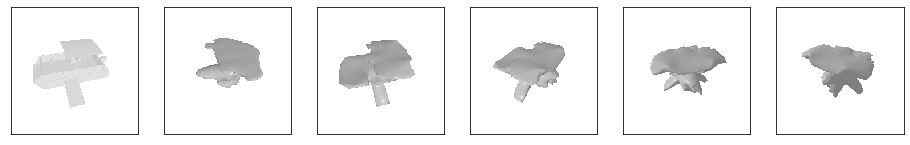

In [6]:
num_azims=20
num_elevs=20
num_dists=40

pose_settings=["gt"]
show_metrics = False

results_df = pd.DataFrame()
all_refinement_info = {}
for instance in instances:
    input_img_path = os.path.join(input_img_dir,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_mesh_dir,"{}.obj".format(instance))
    print(input_mesh_path)
    gt_mesh_path = gt_shapes_dict[instance.split("_")[0]]
    with torch.no_grad():
        input_mesh = general_utils.load_untextured_mesh(input_mesh_path, device)
        gt_mesh = general_utils.load_untextured_mesh(gt_mesh_path, device)
    input_trimesh= trimesh.load(input_mesh_path)
    gt_trimesh = trimesh.load(gt_mesh_path)
    mask = np.asarray(input_image)[:,:,3] > 0
    
    instance_info = {"instance": instance}
    
    pose_info_list = []
    if "gt" in pose_settings:
        gt_elev = pose_dict[instance]["elev"]
        gt_azim = pose_dict[instance]["azim"]
        #gt_dist = pose_dict[instance]["dist"]
        _, _, gt_dist, _, _ = brute_force_estimate_dist(input_mesh, mask, gt_azim, gt_elev, num_dists, device)
        pose_info_list.append([gt_dist.item(), gt_elev, gt_azim, "gt"])
    if "bf" in pose_settings:
        bf_pred_azim, bf_pred_elev, bf_pred_dist, _, _ = brute_force_estimate_pose(input_mesh, mask, num_azims, num_elevs, num_dists, device)
        pose_info_list.append([bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"])
        
    for (dist, elev, azim, name) in pose_info_list:
        #if dataset_type == "pix3d":
        #    azim = azim - 90
        #dist = float(dist)
        #elev = float(elev)
        #azim = float(azim)
        print(dist, elev, azim, name)
        if show_metrics:
            input_metrics_dict, input_debug_dict = eval_utils.eval_metrics(input_image, input_trimesh, input_mesh, gt_trimesh, 
                                                                           gt_mesh, device, metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1"],
                                                                           pred_azim=azim, pred_elev=elev, pred_dist=dist)
            instance_info = {**instance_info, **{"original_{}_{}".format(name, metric):input_metrics_dict[metric] for metric in input_metrics_dict}}
            print("Input mesh metrics: {}".format(input_metrics_dict))
        
        
        
        mesh_refiner = MeshRefiner(cfg, device)
        refined_mesh, refinement_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
        refinement_info["refined_mesh"] = refined_mesh
        all_refinement_info[instance] = refinement_info
        refined_mesh_path = os.path.join("notebooks/out", "{}_{}.obj".format(instance, name))
        save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
        refined_trimesh = trimesh.load(refined_mesh_path)
        refined_mesh = general_utils.load_untextured_mesh(refined_mesh_path, device)
        if show_metrics:
            refined_metrics_dict, refined_debug_dict = eval_utils.eval_metrics(input_image, refined_trimesh, refined_mesh, gt_trimesh, gt_mesh, device, 
                                                                          metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1"],
                                                                          pred_azim=azim, pred_elev=elev, pred_dist=dist)
            print("Refined mesh metrics: {}".format(refined_metrics_dict))
            instance_info = {**instance_info, **{"refined_{}_{}".format(name, metric):refined_metrics_dict[metric] for metric in refined_metrics_dict}}

        refinement_info["loss_info"].plot.line(x='iteration', y='total_loss', title="{}".format(instance))
        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)
    
    results_df = results_df.append(instance_info, ignore_index=True)
    print("=========================================================================================")


In [7]:
# converts conf_scores in [0,1] to rgb from red to green.
# input is a (num_verts, 1) numpy array
def sym_conf_to_rgb(sym_conf_scores):
    sym_conf_scores_normalized = (sym_conf_scores-np.min(sym_conf_scores))/(np.max(sym_conf_scores)-np.min(sym_conf_scores))
    rgb_conf_scores = []
    for conf_score in sym_conf_scores_normalized[:,0]:
        if conf_score < 0.5:
            rgb_conf_scores.append([1,conf_score,0])
        else:
            rgb_conf_scores.append([1-conf_score,1,0])
    return np.array(rgb_conf_scores)

def sym_conf_to_bw(sym_conf_scores):
    sym_conf_scores_normalized = (sym_conf_scores-np.min(sym_conf_scores))/(np.max(sym_conf_scores)-np.min(sym_conf_scores))
    rgb_conf_scores = []
    for conf_score in sym_conf_scores_normalized[:,0]:
        rgb_conf_scores.append([conf_score, conf_score, conf_score])
    return np.array(rgb_conf_scores)

def render_and_show(mesh, device, dist=1.3, elev=35, azim=25):
    R, T = look_at_view_transform(dist, elev, azim) 
    render = general_utils.render_mesh(mesh, R, T, device)
    plt.imshow(render[0, ..., :3].detach().cpu().numpy())

203c2cac2c46e06c320fa6e2cd857828
[[-0.64641905]
 [-0.6329991 ]
 [-0.6188605 ]
 ...
 [13.8376465 ]
 [13.949149  ]
 [13.949219  ]]


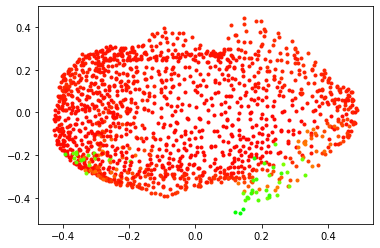

2362039302d80f99f2c9de96bdb467eb
[[0.37358963]
 [0.38715422]
 [0.39080602]
 ...
 [5.626835  ]
 [6.401787  ]
 [7.2468038 ]]


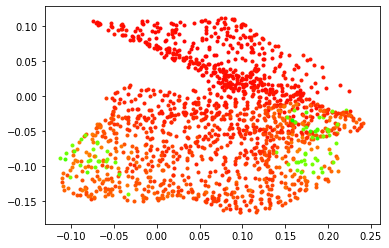

e5a3728a3b5a7ecd1d2d2f3b717d35d5
[[0.01824091]
 [0.01849183]
 [0.03412323]
 ...
 [2.115483  ]
 [2.1742296 ]
 [2.1800864 ]]


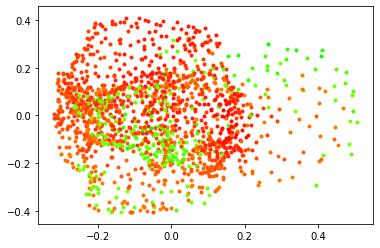

In [8]:
for instance in all_refinement_info:
    print("=============================================================================================")
    print(instance)
    sym_conf_scores = all_refinement_info[instance]["sym_conf_scores"]
    print(np.sort(sym_conf_scores.numpy(), axis=0))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    refined_mesh = all_refinement_info[instance]["refined_mesh"]
    mesh_verts = refined_mesh.verts_packed()
    mesh_rgb_verts = sym_conf_to_rgb(sym_conf_scores.numpy())
    num_verts = sym_conf_scores.shape[0]
    for i in range(num_verts):
        x = mesh_verts[i][0].item()
        y = mesh_verts[i][1].item()
        z = mesh_verts[i][2].item()
        color = np.expand_dims(mesh_rgb_verts[i], 0)
        ax.scatter(x, z, c=color, marker='.')
    plt.show()

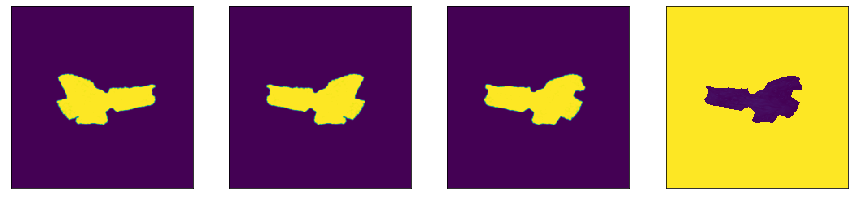

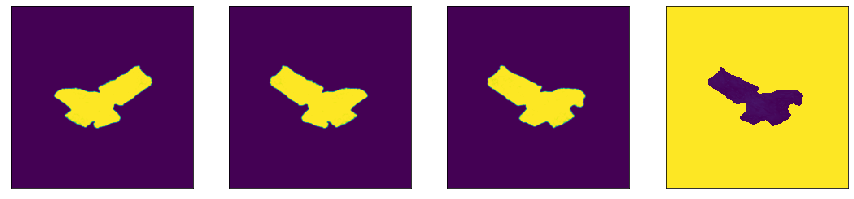

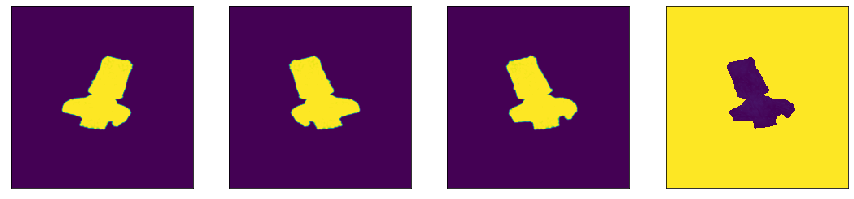

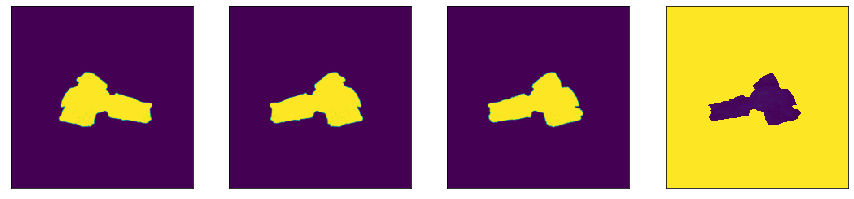

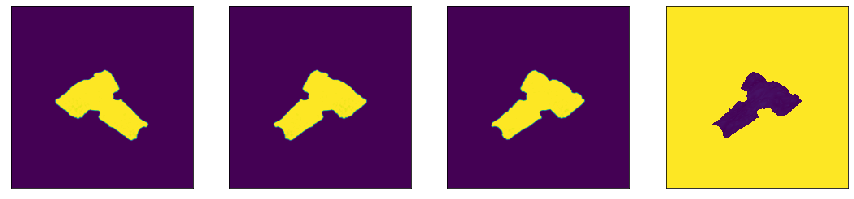

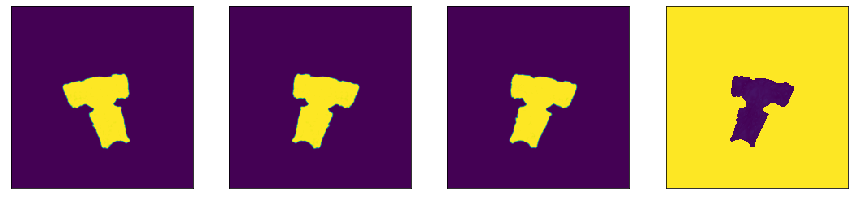

In [27]:
sil = True
for sym_quad in refinement_info["img_sym_loss_debug_imgs"]:
    fig, ax = plt.subplots(nrows=1, ncols=4, squeeze=False, figsize=(15,10))
    for i, render in enumerate(sym_quad):
        if sil:
            ax[0][i].imshow(render.detach().cpu().numpy())
        else:
            ax[0][i].imshow(render[..., 0].detach().cpu().numpy())
        ax[0][i].xaxis.set_visible(False)
        ax[0][i].yaxis.set_visible(False)
    plt.show()
    
    

In [42]:
#refined_mesh.textures = TexturesVertex(verts_features = torch.tensor(mesh_rgb_verts, dtype=torch.float32).unsqueeze(0).to(device))
#mesh_bw_verts = sym_conf_to_bw(refinement_info["sym_conf_scores"].numpy())
#refined_mesh.textures = TexturesVertex(verts_features = torch.tensor(mesh_bw_verts, dtype=torch.float32).unsqueeze(0).to(device))


torch.Size([1, 512, 512, 4])


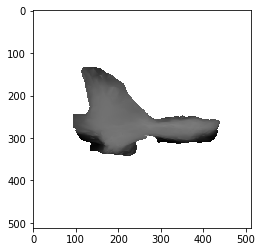

In [64]:
render_and_show(refined_mesh, device, dist=1.4, elev=-45, azim=0)

# Legacy

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

num_verts = refinement_info["sym_conf_scores"].shape[0]
mesh_verts = refined_mesh.verts_packed()
for i in range(num_verts):
    x = mesh_verts[i][0].item()
    y = mesh_verts[i][1].item()
    z = mesh_verts[i][2].item()
    sym_conf = sym_conf_scores_normalized[i][0]
    color = np.array([[sym_conf,0,0]])
    ax.scatter(x, y, z, c=color, marker='.')

plt.show()